# Communication link budget calculator

This tutorial demonstrates how to model a communications system including transmitters and receivers, and calculate link budgets considering factors like terrain, rain models, and atmospheric losses using Python and PySTK. It is inspired by [this](https://help.agi.com/stk/Content/training/StartCommunications.htm) tutorial.

## What are communications links, and how are they evaluated?

Communication links define the ways that a transmitter and a receiver access each other. STK allows the modeling of two kinds of links: basic and multi-hop. A basic communications link is access between just a single transmitter and a single receiver. A multi-hop communications link is defined by a group of communication objects consisting of a transmitter, receiver, re-transmitter, and another receiver. STK also allows setting constraints on communication links, including terrain masking constraints.

Communications links in STK can be analyzed using link budget reports, which include all the link parameters associated with the selected receiver or transmitter. Link budget reports take light speed delay into account. They also take computed refraction into account if enabled on the transmitter or receiver objects. Link budget reports include many communications-specific fields, including EIRP (effective isotropic radiated power in the link direction), C/N (Carrier-to-Noise ratio at the receiver input), Eb/No (Signal-to-Noise ratio at the receiver), and BER (Bit Error Rate). Link budget reports can also include access-specific information, such as the loss calculated by different selected models, including atmospheric, rain, cloud/fog, and terrain models.

## Problem statement

A team of scientists is monitoring glacial meltwater in a remote, mountainous location (latitude $47.5605^\circ$, longitude $11.5027^\circ$). They need to determine how their location impacts a link budget between them and a low earth orbit (LEO), Earth observation satellite which is downloading data to the team. The satellite has a simple transmitter with an isotropic antenna pattern, a frequency of $1.7045$ GHz, an EIRP of $10$ dBW, a data rate of $4.2$ Mb/sec, and a right-hand circular polarization. The camp's receiver is steerable, points at the satellite, and is placed on a half power sensor located $6$ ft above the ground, with a frequency of $1.7045$ GHz and $1.6$ m. The receiver has a parabolic antenna with a design frequency of $1.7$ GHz, a $1.6$ m diameter, and right-hand circular polarization.

Model and analyze a link budget between the ground site and the Earth observation satellite, taking into account different factors such as terrain, rain and atmospheric absorption, and system noise temperature from sun, atmosphere, rain, and cosmic background.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("Communications")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

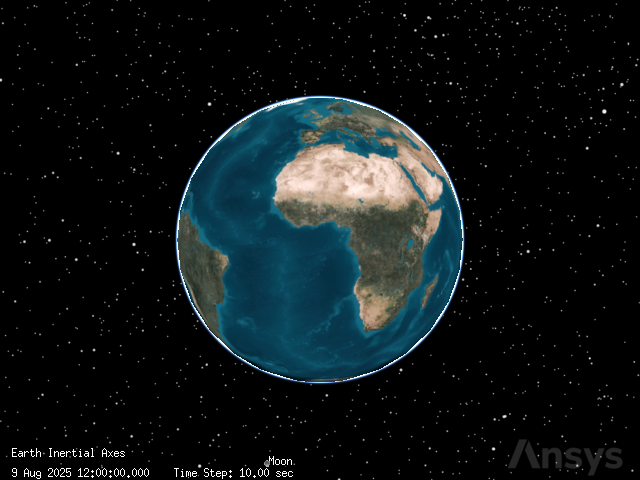

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe = GlobeWidget(root, 640, 480)
globe.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [4]:
scenario = root.current_scenario
scenario.set_time_period("15 Mar 2024 06:00:00.000", "16 Mar 2024 06:00:00.000")
root.rewind()

## Add analytical and visual terrain

Use an STK terrain file (file extension PDTT) included with the STK install to add analytical terrain to the scenario. The file contains information on the terrain around the scientists' camp site. Use a Connect command to find the path to the RaistingStation.pdtt file:

In [5]:
import pathlib

from ansys.stk.core.stkobjects import TerrainFileType


install_dir = root.execute_command("GetDirectory / STKHome")[0]
terrain_path = str(
    pathlib.Path(install_dir)
    / "Data"
    / "Resources"
    / "stktraining"
    / "imagery"
    / "RaistingStation.pdtt"
)

Then, add the file to the Earth central body's terrain collection:

In [6]:
terrain = scenario.terrain.item("Earth").terrain_collection.add(
    terrain_path, TerrainFileType.PDTT
)

This file is used for analysis by default after it is inserted.

## Add a satellite

The Earth observation satellite is in a sun-synchronous orbit. It can thus be modelled by an SGP4 propagator, which is used for LEO satellites. The satellite communicating with the camp has a common name of TerraSarX, which corresponds to a space surveillance catalog number of $31698$.

To add the satellite, first insert a satellite object:

In [7]:
from ansys.stk.core.stkobjects import PropagatorType, STKObjectType


satellite = root.current_scenario.children.new(
    STKObjectType.SATELLITE, "TerraSarX_31698"
)

Then, set the satellite's propagator to the SGP4 propagator:

In [8]:
satellite.set_propagator_type(PropagatorType.SGP4)
propagator = satellite.propagator

Finally, use the propagator's `common_tasks` property to add the satellite's orbit from an online source, and propagate the satellite:

In [9]:
propagator.common_tasks.add_segments_from_online_source("31698")
propagator.propagate()

## Add the camp site

Add a place object to represent the camp site:

In [10]:
camp_site = root.current_scenario.children.new(STKObjectType.PLACE, "CampSite")

Assign the site's position to latitude $47.5605^\circ$ and longitude $11.5027^\circ$, with an elevation of $6$ ft ($0.0018288$ km) to simulate the height of the equipment at the site:

In [11]:
camp_site.position.assign_planetodetic(47.5605, 11.5027, 0.0018288)

## Model a simple transmitter

The satellite has a simple transmitter model, a model type which uses an isotropic, omnidirectional antenna, which is an ideal spherical pattern antenna with constant gain. Insert the transmitter on the satellite:

In [12]:
transmitter = satellite.children.new(STKObjectType.TRANSMITTER, "DownloadTransmitter")

The transmitter's `model` property now contains a `TransmitterModelSimple` object. Set the model's frequency to $1.7045$ GHz:

In [13]:
from ansys.stk.core.stkobjects import TransmitterModelSimple

In [14]:
transmitter_model = TransmitterModelSimple(
    transmitter.model_component_linking.component
)
transmitter_model.frequency = 1.7045

Then, set the model's EIRP, which is the effective isotropic radiated power at the output of the transmit antenna. Set the EIRP to $10$ dBW:

In [15]:
transmitter_model.eirp = 10

Next, set the model's data rate to $4.2$ Mb/sec:

In [16]:
transmitter_model.data_rate = 4.2

Then, enable polarization on the model:

In [17]:
transmitter_model.enable_polarization = True

Finally, set the model's polarization type to right-hand circular:

In [18]:
from ansys.stk.core.stkobjects import PolarizationType


transmitter_model.set_polarization_type(PolarizationType.RIGHT_HAND_CIRCULAR)

## Add a steerable sensor

The receiver antenna at the camp site is steerable. To create a steering device, add a sensor object:

In [19]:
sensor = camp_site.children.new(STKObjectType.SENSOR, "ServoMotor")

Then, set the sensor's pattern to a half power pattern, which is designed to visually model parabolic antennas. The sensor half angle is determined by frequency and antenna diameter.

In [20]:
from ansys.stk.core.stkobjects import SensorPattern


sensor.set_pattern_type(SensorPattern.HALF_POWER)

The sensor's `pattern` property now holds a `SensorHalfPowerPattern` object, through which it is possible to configure the half power model. First, set the sensor's frequency to $1.7045$ GHz:

In [21]:
sensor.pattern.frequency = 1.7045

Then, set the sensor's antenna diameter to $1.6$ m:

In [22]:
sensor.pattern.antenna_diameter = 1.6

The sensor is steerable and tracks the satellite, so set the sensor's pointing type to targeted:

In [23]:
from ansys.stk.core.stkobjects import SensorPointing


sensor.set_pointing_type(SensorPointing.TARGETED)

The sensor's `pointing` property now holds a `SensorPointingTargeted` object, through which it is possible to set the satellite as the sensor's target:

In [24]:
sensor.pointing.targets.add("Satellite/TerraSarX_31698")

## Calculate access

Get and compute the access between the camp site's sensor and the satellite:

In [25]:
sensor_to_satellite_access = sensor.get_access_to_object(satellite)
sensor_to_satellite_access.compute_access()

Then, get the access data during the entire scenario as a dataframe:

In [26]:
sensor_to_satellite_access_df = (
    sensor_to_satellite_access.data_providers.item("Access Data")
    .execute(scenario.start_time, scenario.stop_time)
    .data_sets.to_pandas_dataframe()
)
sensor_to_satellite_access_df

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,15 Mar 2024 06:22:09.458394650,15 Mar 2024 06:33:14.874552309,665.4161576585711,N/A,92880,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,33W,521.7361574932914,7745.443597705119,33WWT2173645444,30R,419.93311379561754,3183.561712039982,30RVS1993383562
1,2,15 Mar 2024 07:58:01.500105812,15 Mar 2024 08:02:54.221900294,292.7217944814738,N/A,92881,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,29W,366.3935165120598,7345.475509726332,29WLP6639445476,27U,429.62145253038983,5346.728487058212,27UVP2962146728
2,3,15 Mar 2024 15:31:09.921082116,15 Mar 2024 15:41:19.040164169,609.1190820532502,N/A,92886,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,36S,488.9442601190258,3580.2257910631242,36SVA8894480226,33W,473.4377277545171,7750.483657208226,33WVT7343850484
3,4,15 Mar 2024 17:04:09.317277119,15 Mar 2024 17:15:35.046016598,685.7287394791856,N/A,92887,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,32R,684.1302660527213,2804.2680862111097,32RPP8413004268,29W,581.3720108624226,7521.636185530031,29WNR8137221636
4,5,15 Mar 2024 18:42:20.852340085,15 Mar 2024 18:47:07.001005909,286.14866582359537,N/A,92888,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,28S,411.79831536120537,4198.952095364672,28SDG1179898952,27U,413.58106896236995,6176.115365635918,27UVB1358176115
5,6,16 Mar 2024 04:31:32.112160260,16 Mar 2024 04:41:28.374312584,596.2621523233247,N/A,92894,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,37W,469.61327075042703,7158.601010664799,37WDM6961358601,34R,788.3165946467708,3051.857144479871,34RGR8831751857


The sensor is able to access the satellite six times throughout the duration of the scenario.

The access between the sensor and the satellite can be seen in the 3D graphics window approximately $1389$ seconds after the scenario begins:

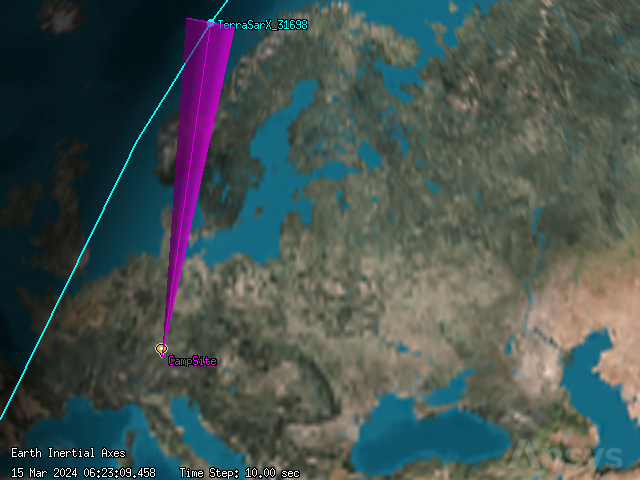

In [27]:
root.current_time = 1389.458394
globe.camera.position = [2703.568833967754, -5862.711497073381, 9424.82507431983]
globe.show()

## Model the receiver

The sensor's receiver is modelled using a complex receiver model, which allows selecting among a variety of analytical and realistic antenna models and defining the characteristics of the selected antenna type.

First, add the receiver on the sensor:

In [28]:
receiver = sensor.children.new(STKObjectType.RECEIVER, "DownloadReceiver")

Then, set the receiver's model type to the complex receiver model:

In [29]:
receiver.model_component_linking.set_component("Complex Receiver Model")

Next, use the model's `antenna_control` property to set the receiver's embedded model to a parabolic antenna:

In [30]:
from ansys.stk.core.stkobjects import ReceiverModelComplex

In [31]:
receiver_model = ReceiverModelComplex(receiver.model_component_linking.component)
receiver_model.antenna_control.embedded_model_component_linking.set_component(
    "Parabolic"
)

The receiver model's antenna control's `embedded_model` property now holds an `AntennaModelParabolic` object, through which it is possible to configure the antenna model. First, configure the antenna model to use diameter as its input type:

In [32]:
from ansys.stk.core.stkobjects import AntennaModelInputType, AntennaModelParabolic


antenna_control = AntennaModelParabolic(
    receiver_model.antenna_control.embedded_model_component_linking.component
)
antenna_control.input_type = AntennaModelInputType.DIAMETER

Then, set the diameter to $1.6$ m:

In [33]:
antenna_control.diameter = 1.6

Set the design frequency to $1.7$ GHz:

In [34]:
antenna_control.design_frequency = 1.7

Next, enable the use of polarization on the receiver model:

In [35]:
receiver_model.enable_polarization = True

The receiver's polarization type is the same as the transmitter's polarization, so set the model's polarization type to right-hand circular:

In [36]:
receiver_model.set_polarization_type(PolarizationType.RIGHT_HAND_CIRCULAR)

## Calculate access

Get and calculate the access between the receiver and transmitter:

In [37]:
receiver_basic_access = receiver.get_access_to_object(transmitter)
receiver_basic_access.compute_access()

Then, get the link information for the access for the entire scenario, using a time step of $30$ s:

In [38]:
receiver_basic_link_df = (
    receiver_basic_access.data_providers.item("Link Information")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)

Get the columns corresponding to time, atmospheric loss (atmos loss), rain loss, EIRP in the link direction (eirp), received isotropic power at the receiver antenna (rcvd. iso. power), power flux density at the receiver antenna (flux density), receiver gain over equivalent noise temperature (g/T), carrier-to-noise density at the receiver input (c/no), bandwidth, carrier-to-noise ratio at the receiver input (c/n), signal-to-noise ratio at the receiver (eb/no), bit error rate (ber), and calculated system noise temperatures (tatmos, train, tsun, tearth, tcosmic, tantenna, tequivalent):

In [39]:
link_budget_columns = [
    "time",
    "atmos loss",
    "rain loss",
    "eirp",
    "rcvd. frequency",
    "rcvd. iso. power",
    "flux density",
    "g/t",
    "c/no",
    "bandwidth",
    "c/n",
    "eb/no",
    "ber",
    "tatmos",
    "train",
    "tsun",
    "tearth",
    "tcosmic",
    "tantenna",
    "tequivalent",
]
receiver_basic_link_df.head(10)[link_budget_columns]

,time,atmos loss,rain loss,eirp,rcvd. frequency,rcvd. iso. power,flux density,g/t,c/no,bandwidth,c/n,eb/no,ber,tatmos,train,tsun,tearth,tcosmic,tantenna,tequivalent
0,15 Mar 2024 06:22:09.458394650,0.0,0.0,10.0,1.704539,-155.457601,-129.369976,1.900768,15.042306,8.4,5.799513,8.809813,0.000048,0.0,0.0,0.0,0.0,0.0,None,290.0
1,15 Mar 2024 07:58:01.500105812,0.0,0.0,10.0,1.704517,-155.454205,-129.36658,1.900657,15.045591,8.4,5.802798,8.813098,0.000048,0.0,0.0,0.0,0.0,0.0,None,290.0
2,15 Mar 2024 15:31:09.921082116,0.0,0.0,10.0,1.704535,-155.391722,-129.304097,1.900751,15.108167,8.4,5.865375,8.875675,0.000043,0.0,0.0,0.0,0.0,0.0,None,290.0
3,15 Mar 2024 17:04:09.317277119,0.0,0.0,10.0,1.704539,-155.372865,-129.285241,1.900771,15.127045,8.4,5.884252,8.894552,0.000041,0.0,0.0,0.0,0.0,0.0,None,290.0
4,15 Mar 2024 18:42:20.852340085,0.0,0.0,10.0,1.704515,-155.405099,-129.317474,1.900647,15.094687,8.4,5.851894,8.862194,0.000044,0.0,0.0,0.0,0.0,0.0,None,290.0
5,16 Mar 2024 04:31:32.112160260,0.0,0.0,10.0,1.704533,-155.452536,-129.364911,1.90074,15.047343,8.4,5.80455,8.81485,0.000048,0.0,0.0,0.0,0.0,0.0,None,290.0
6,15 Mar 2024 06:22:39.000000000,0.0,0.0,10.0,1.704539,-154.765272,-128.677647,1.900766,15.734634,8.4,6.491841,9.502141,0.000012,0.0,0.0,0.0,0.0,0.0,None,290.0
7,15 Mar 2024 07:58:31.000000000,0.0,0.0,10.0,1.704514,-155.18293,-129.095305,1.900642,15.316851,8.4,6.074058,9.084358,0.000029,0.0,0.0,0.0,0.0,0.0,None,290.0
8,15 Mar 2024 15:31:39.000000000,0.0,0.0,10.0,1.704535,-154.772723,-128.685098,1.900746,15.727162,8.4,6.484369,9.494669,0.000012,0.0,0.0,0.0,0.0,0.0,None,290.0
9,15 Mar 2024 17:04:39.000000000,0.0,0.0,10.0,1.704539,-154.657114,-128.56949,1.90077,15.842795,8.4,6.600002,9.610302,0.00001,0.0,0.0,0.0,0.0,0.0,None,290.0


The dataframe now shows information corresponding to an STK link budget report. From the data, it is possible to see that as the satellite rises over the horizon of the central body, the site receives transmissions. When the satellite falls below the horizon, the site loses transmissions. Additionally, because the access calculation does not include any environmental factor models or system noise temperature considerations, the columns corresponding to the losses/noise all have values of 0.

## Add terrain to the analysis

Next, add a terrain mask to the receiver to add terrain into the access analysis. A terrain mask causes STK to constrain access to an object by any terrain data in the line of sight to which access is being calculated. Add a terrain mask access constraint:

In [40]:
from ansys.stk.core.stkobjects import AccessConstraintType


terrain_constraint = receiver.access_constraints.add_constraint(
    AccessConstraintType.TERRAIN_MASK
)

Recalculate the access between the receiver and transmitter, then get the data corresponding to a link budget report:

In [41]:
receiver_basic_access.compute_access()
receiver_terrain_link_df = (
    receiver_basic_access.data_providers.item("Link Information")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)
receiver_terrain_link_df.head(10)[link_budget_columns]

,time,atmos loss,rain loss,eirp,rcvd. frequency,rcvd. iso. power,flux density,g/t,c/no,bandwidth,c/n,eb/no,ber,tatmos,train,tsun,tearth,tcosmic,tantenna,tequivalent
0,15 Mar 2024 06:23:47.759570010,0.0,0.0,10.0,1.704537,-152.945069,-126.857445,1.900759,17.554828,8.4,8.312036,11.322336,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
1,15 Mar 2024 15:33:36.548124287,0.0,0.0,10.0,1.704527,-152.052659,-125.965034,1.900709,18.447189,8.4,9.204396,12.214696,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
2,15 Mar 2024 17:07:34.413895835,0.0,0.0,10.0,1.704534,-148.927067,-122.839442,1.900741,21.572814,8.4,12.330021,15.340321,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
3,16 Mar 2024 04:32:28.173285490,0.0,0.0,10.0,1.704531,-154.328235,-128.24061,1.900728,16.171633,8.4,6.92884,9.93914,0.000004,0.0,0.0,0.0,0.0,0.0,None,290.0
4,15 Mar 2024 06:24:17.000000000,0.0,0.0,10.0,1.704536,-152.071471,-125.983846,1.900753,18.428421,8.4,9.185629,12.195928,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
5,15 Mar 2024 15:34:06.000000000,0.0,0.0,10.0,1.704524,-151.374141,-125.286516,1.900692,19.125691,8.4,9.882898,12.893198,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
6,15 Mar 2024 17:08:04.000000000,0.0,0.0,10.0,1.70453,-147.664614,-121.57699,1.900725,22.83525,8.4,13.592457,16.602757,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
7,16 Mar 2024 04:32:58.000000000,0.0,0.0,10.0,1.704529,-153.707919,-127.620295,1.90072,16.791939,8.4,7.549146,10.559446,0.000001,0.0,0.0,0.0,0.0,0.0,None,290.0
8,15 Mar 2024 06:24:47.000000000,0.0,0.0,10.0,1.704534,-151.110464,-125.02284,1.900746,19.38942,8.4,10.146627,13.156927,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
9,15 Mar 2024 15:34:36.000000000,0.0,0.0,10.0,1.70452,-150.737395,-124.64977,1.900671,19.762415,8.4,10.519622,13.529922,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0


Next, get the access data for the updated access:

In [42]:
receiver_basic_access.data_providers.item("Access Data").execute(
    scenario.start_time, scenario.stop_time
).data_sets.to_pandas_dataframe()

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,15 Mar 2024 06:23:47.759570010,15 Mar 2024 06:30:05.292544675,377.53297466502795,N/A,92880,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,32V,542.9914547844054,7093.029825590829,32VNR4299193030,30T,693.268160537319,4503.764360442385,30TXL9326803764
1,2,15 Mar 2024 15:33:36.548124287,15 Mar 2024 15:39:49.757492637,373.2093683504718,N/A,92886,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,36T,281.6489596792608,4602.228375321448,36TTM8164902228,34W,432.3377418050118,7159.205100170075,34WDS3233859205
2,3,15 Mar 2024 17:07:34.413895835,15 Mar 2024 17:13:56.389724097,381.97582826247526,N/A,92887,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,32S,380.03813667867576,4231.048799749039,32SLH8003831049,30V,544.3636974596918,6859.598604629627,30VWP4436459599
3,4,16 Mar 2024 04:32:28.173285490,16 Mar 2024 04:38:33.018850881,364.84556539097684,N/A,92894,47.560500000000005,11.502699999999999,0.8701674116786334,47.560500000000005,...,5270.488855657932,32TPT8826570489,36V,657.7641124914722,6783.648184475049,36VXN5776483648,35S,474.6037894108813,4268.177771106299,35SMC7460468178


Before adding a terrain mask, there were $6$ accesses between the receiver and transmitter. By adding a terrain mask, the accesses blocked by terrain have been removed from the report, and there are now only $4$ accesses between the receiver and transmitter.

## Model environmental factors

Environmental factors can affect the performance of a communications link. In STK, it is possible to enable or disable the use of different environmental factors at three levels: scenario, platform (facilities, places, targets, and all vehicles except satellites), and subobject (transmitter, receiver, radar, and antenna). In this case, since the scenario only includes a single receiver/transmitter pair, set the environmental factors at the scenario level.

First, add a rain model, which is used to estimate the amount of degradation (or fading) of signal when passing through rain. The degradation is primarily due to absorption by water molecules and is a function of frequency and elevation angle. Generally speaking, the rain loss increases with increasing frequency. The loss also increases with decreasing ground elevation angle due to a greater path distance through the portion of the atmosphere where rain occurs. Rain also causes an increase in the antenna noise temperature. Set the `enable_rain_loss` property to `True` on the scenario's RF environment's propagation channel:

In [43]:
scenario.rf_environment.propagation_channel.enable_rain_loss = True

Then, enable the use of the atmospheric absorption model:

In [44]:
scenario.rf_environment.propagation_channel.enable_atmospheric_absorption = True

It is possible to configure which specific model is used for the different environmental factors. However, in this case, the default models are sufficient.

Next, recalculate the access between the receiver and transmitter:

In [45]:
receiver_basic_access.compute_access()
receiver_environmental_link_df = (
    receiver_basic_access.data_providers.item("Link Information")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)
receiver_environmental_link_df.head(10)[link_budget_columns]

,time,atmos loss,rain loss,eirp,rcvd. frequency,rcvd. iso. power,flux density,g/t,c/no,bandwidth,c/n,eb/no,ber,tatmos,train,tsun,tearth,tcosmic,tantenna,tequivalent
0,15 Mar 2024 06:23:47.759570010,0.23797,0.005026,10.0,1.704537,-153.188065,-127.10044,1.900759,17.311833,8.4,8.06904,11.07934,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
1,15 Mar 2024 15:33:36.548124287,0.174104,0.003672,10.0,1.704527,-152.230434,-126.14281,1.900709,18.269414,8.4,9.026621,12.036921,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
2,15 Mar 2024 17:07:34.413895835,0.085919,0.00175,10.0,1.704534,-149.014736,-122.927111,1.900741,21.485144,8.4,12.242352,15.252651,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
3,16 Mar 2024 04:32:28.173285490,0.479177,0.012249,10.0,1.704531,-154.81966,-128.732036,1.900728,15.680207,8.4,6.437414,9.447714,0.000014,0.0,0.0,0.0,0.0,0.0,None,290.0
4,15 Mar 2024 06:24:17.000000000,0.17687,0.003635,10.0,1.704536,-152.251976,-126.164351,1.900753,18.247917,8.4,9.005124,12.015424,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
5,15 Mar 2024 15:34:06.000000000,0.144554,0.002995,10.0,1.704524,-151.52169,-125.434065,1.900692,18.978142,8.4,9.735349,12.745649,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
6,15 Mar 2024 17:08:04.000000000,0.069449,0.001407,10.0,1.70453,-147.735471,-121.647846,1.900725,22.764393,8.4,13.5216,16.5319,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
7,16 Mar 2024 04:32:58.000000000,0.332202,0.007488,10.0,1.704529,-154.047609,-127.959985,1.90072,16.452249,8.4,7.209456,10.219756,0.000002,0.0,0.0,0.0,0.0,0.0,None,290.0
8,15 Mar 2024 06:24:47.000000000,0.136309,0.00276,10.0,1.704534,-151.249533,-125.161908,1.900746,19.250351,8.4,10.007559,13.017859,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0
9,15 Mar 2024 15:34:36.000000000,0.124049,0.00254,10.0,1.70452,-150.863984,-124.77636,1.900671,19.635825,8.4,10.393032,13.403332,0.0,0.0,0.0,0.0,0.0,0.0,None,290.0


After adding environmental factor models, the atmospheric and rain losses are now greater than $0$. However, the losses are minimal, so the losses in C/N and Eb/No are also minimal.

## Model system noise temperature

The receiver's system noise temperature enables specifying the system's inherent noise characteristics, which can help simulate real-world RF situations more accurately. STK can use either a constant system noise temperature value, or can calculate it based off of different noise sources. In this case, configure the receiver model's system noise temperature to use calculated values:

In [46]:
from ansys.stk.core.stkobjects import NoiseTemperatureComputeType


receiver_model.system_noise_temperature.compute_type = (
    NoiseTemperatureComputeType.CALCULATE
)

Do the same for the model's antenna noise temperature:

In [47]:
receiver_model.system_noise_temperature.antenna_noise_temperature.compute_type = (
    NoiseTemperatureComputeType.CALCULATE
)

Then, enable the use of sun, atmosphere, rain, and cosmic background in computations:

In [48]:
receiver_model.system_noise_temperature.antenna_noise_temperature.use_sun = True
receiver_model.system_noise_temperature.antenna_noise_temperature.use_atmosphere = True
receiver_model.system_noise_temperature.antenna_noise_temperature.use_rain = True
receiver_model.system_noise_temperature.antenna_noise_temperature.use_cosmic_background = True

Finally, recompute the access and get the updated link information:

In [49]:
receiver_basic_access.compute_access()
receiver_noise_link_df = (
    receiver_basic_access.data_providers.item("Link Information")
    .execute(scenario.start_time, scenario.stop_time, 30)
    .data_sets.to_pandas_dataframe()
)
receiver_noise_link_df.head(10)[link_budget_columns]

,time,atmos loss,rain loss,eirp,rcvd. frequency,rcvd. iso. power,flux density,g/t,c/no,bandwidth,c/n,eb/no,ber,tatmos,train,tsun,tearth,tcosmic,tantenna,tequivalent
0,15 Mar 2024 06:23:47.759570010,0.23797,0.005026,10.0,1.704537,-153.188065,-127.10044,7.279596,22.69067,8.4,13.447877,16.458177,0.0,6.108648,1.497981,0.000463,0.0,1.35,8.957091,84.045461
1,15 Mar 2024 15:33:36.548124287,0.174104,0.003672,10.0,1.704527,-152.230434,-126.14281,7.366124,23.734829,8.4,14.492036,17.502336,0.0,4.489744,1.458123,0.000346,0.0,1.35,7.298213,82.386583
2,15 Mar 2024 17:07:34.413895835,0.085919,0.00175,10.0,1.704534,-149.014736,-122.927111,7.489463,27.073866,8.4,17.831073,20.841373,0.0,2.228967,1.401542,0.011442,0.0,1.35,4.991951,80.08032
3,16 Mar 2024 04:32:28.173285490,0.479177,0.012249,10.0,1.704531,-154.81966,-128.732036,6.982775,20.762253,8.4,11.519461,14.529761,0.0,12.06549,1.710349,0.0,0.0,1.1256,14.90144,89.98981
4,15 Mar 2024 06:24:17.000000000,0.17687,0.003635,10.0,1.704536,-152.251976,-126.164351,7.362507,23.70967,8.4,14.466878,17.477178,0.0,4.560209,1.457031,0.000458,0.0,1.35,7.367698,82.456068
5,15 Mar 2024 15:34:06.000000000,0.144554,0.002995,10.0,1.704524,-151.52169,-125.434065,7.407127,24.484576,8.4,15.241783,18.252083,0.0,3.735207,1.438195,0.000325,0.0,1.35,6.523728,81.612097
6,15 Mar 2024 17:08:04.000000000,0.069449,0.001407,10.0,1.70453,-147.735471,-121.647846,7.513623,28.377291,8.4,19.134498,22.144798,0.0,1.803877,1.391453,0.002083,0.0,1.35,4.547414,79.635783
7,16 Mar 2024 04:32:58.000000000,0.332202,0.007488,10.0,1.704529,-154.047609,-127.959985,7.224173,21.775703,8.4,12.53291,15.54321,0.0,8.465337,1.570418,0.0,0.0,0.0,10.035755,85.124125
8,15 Mar 2024 06:24:47.000000000,0.136309,0.00276,10.0,1.704534,-151.249533,-125.161908,7.418791,24.768397,8.4,15.525604,18.535904,0.0,3.524091,1.431281,0.00045,0.0,1.35,6.305823,81.394192
9,15 Mar 2024 15:34:36.000000000,0.124049,0.00254,10.0,1.70452,-150.863984,-124.77636,7.435875,25.17103,8.4,15.928237,18.938537,0.0,3.209762,1.424816,0.000302,0.0,1.35,5.98488,81.073249


There are now non-zero values in the tatmos, train, tsun, tcosmic, tantenna, and tequivalent columns. Calculating system noise temperature improved the report and extended the time available for downloading data.

## Plot the different link budgets

Visualize the calculated link budgets under the different modeling factors:

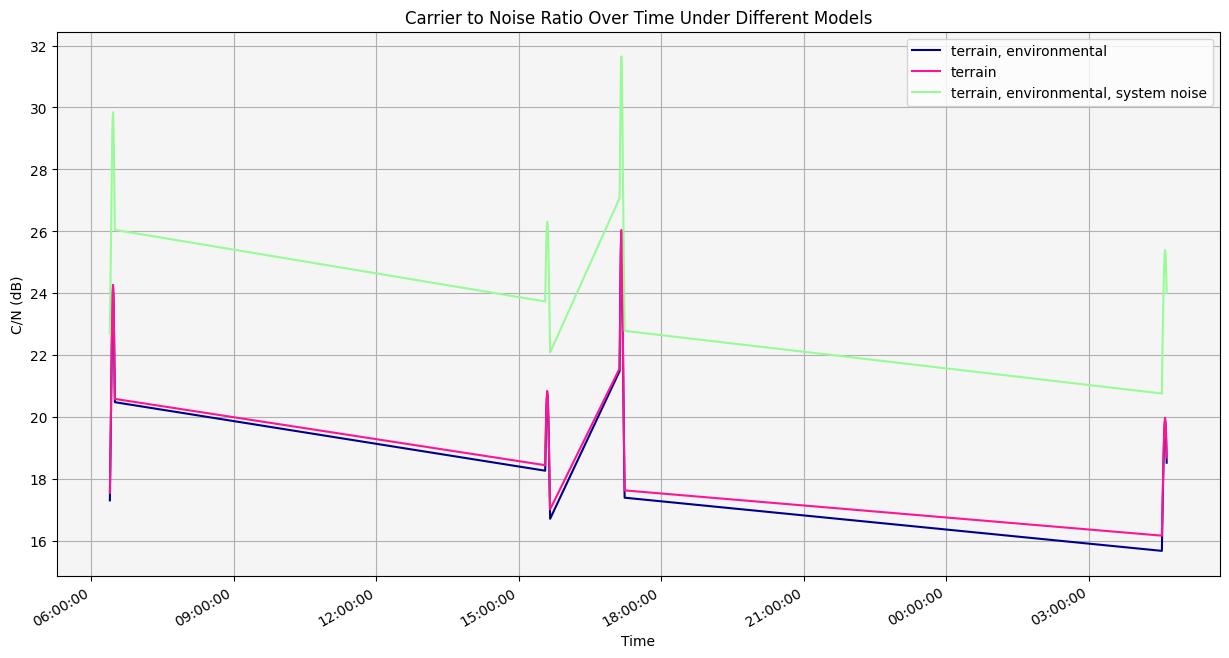

In [50]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Create plot
fig, ax = plt.subplots()

# Format data
receiver_environmental_link_df["time"] = pd.to_datetime(
    receiver_environmental_link_df["time"]
)
receiver_environmental_link_df.sort_values(by="time", inplace=True)
receiver_terrain_link_df["time"] = pd.to_datetime(receiver_terrain_link_df["time"])
receiver_terrain_link_df.sort_values(by="time", inplace=True)
receiver_noise_link_df["time"] = pd.to_datetime(receiver_noise_link_df["time"])
receiver_noise_link_df.sort_values(by="time", inplace=True)

# Plot dataframes
receiver_environmental_link_df.plot(
    x="time", y="c/no", ax=ax, label="terrain, environmental", color="darkblue"
)
receiver_terrain_link_df.plot(
    x="time", y="c/no", ax=ax, label="terrain", color="deeppink"
)
receiver_noise_link_df.plot(
    x="time",
    y="c/no",
    ax=ax,
    label="terrain, environmental, system noise",
    color="palegreen",
)

# Configure plot style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")

# Set title and labels
ax.set_title("Carrier to Noise Ratio Over Time Under Different Models")
ax.set_xlabel("Time")
ax.set_ylabel("C/N (dB)")

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(formatter)

# Set figure size
fig.set_size_inches(15, 8)

# Show figure
plt.show()

The model accounting for only terrain has similar C/N values to the model accounting for terrain and environmental factors, as the losses from environmental factors were minimal in this analysis. The model accounting for terrain, environmental factors, and system noise consistently had the highest C/N values, as calculating system noise temperature improved the link budget.